This practical work, on motion estimation, has 2 different parts, corresponding to two families of algorithms that we have seen in class:
- Block matching algorithms
- Optic flow

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d

# I - Block matching algorithms
## I-1 - Unregularized algorithms
### I-1-a - Unregularized SSD-based algorithm

First, read the two images 'flower_cif_1.mat' and 'flower_cif_1.mat', which are two consecutive frames of a video sequence. You will have to estimate the motion between these frame, using block matching algorithms.

In [2]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

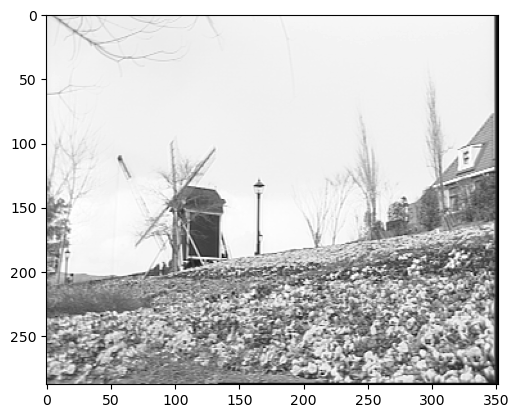

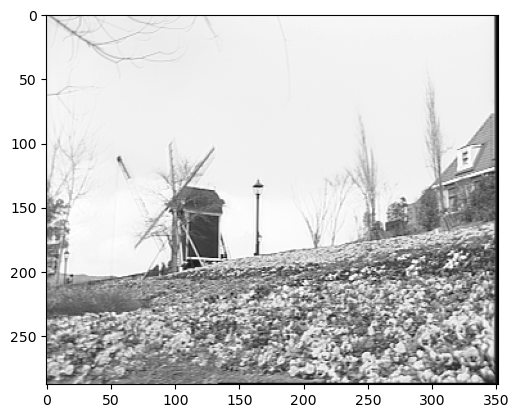

In [4]:
plt.figure()
plt.imshow(im1,cmap='gray')
plt.figure()
plt.imshow(im2,cmap='gray')

First, you will have to encode a block matching using the SSD criterion. Some default values of the algorithm are given below: the number of column and rows in each block, and the search radius.

In [5]:
brow = 16 # Number of rows per block
bcol = 16 # Number of columns per block
search_radius = 8 # Search radius

Fill the me_ssd function in the cell below. First, implement the unregularized part of the function (you will implement the regularized one later). Do not pay attention to the computePredictor and initVector (we will speak about them later on).

In [6]:
#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR.astype(float) - CUR.astype(float))**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV

In [34]:
#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    
    # Non-regularized search
    if lamb == 0.:
        for r in range(0, cur.shape[0], brow):
            for c in range(0, cur.shape[1], bcol):
                B = cur[r:r+brow, c:c+bcol]
                costMin = float('inf')
                Rbest = None
                
                for dcol in range(0, 2*search + 1):
                    for drow in range(0, 2*search + 1):
                        R = ref_extended[r+drow:r+drow+brow, c+dcol:c+dcol+bcol]
                        cost = np.sum((B - R) ** 2)
                        
                        if cost < costMin:
                            costMin = cost
                            Rbest = R
                            best_drow, best_dcol = drow, dcol
                
                mvf[r:r+brow, c:c+bcol, 0] = best_drow
                mvf[r:r+brow, c:c+bcol, 1] = best_dcol
                prediction[r:r+brow, c:c+bcol] = Rbest
                
    else: # Regularized search
        for r in range(0, cur.shape[0], brow):
            for c in range(0, cur.shape[1], bcol):
                B = cur[r:r+brow, c:c+bcol]
                costMin = float('inf')
                Rbest = None
                pV = computePredictor(r, c, brow, bcol, mvf, ref, cur)
                
                for dcol in range(0, 2*search + 1):
                    for drow in range(0, 2*search + 1):
                        R = ref_extended[r+drow:r+drow+brow, c+dcol:c+dcol+bcol]
                        ssd_cost = np.sum((B - R) ** 2)
                        reg_cost = lamb * np.sum((pV - np.array([drow, dcol])) ** 2)
                        total_cost = ssd_cost + reg_cost

                        if total_cost < costMin:
                            costMin = total_cost
                            Rbest = R
                            best_drow, best_dcol = drow, dcol

                mvf[r:r+brow, c:c+bcol, 0] = best_drow
                mvf[r:r+brow, c:c+bcol, 1] = best_dcol
                prediction[r:r+brow, c:c+bcol] = Rbest
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [10]:
mvf_ssd, prediction =  me_ssd(im2, im1, brow, bcol, search_radius)

Using the function displayMVF, show the motion vector field. Write your remarks. Are there errors? If yes, where and why?

Change the block size and the search area radius. How does it impact your results?

In [11]:
def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)
    
    return

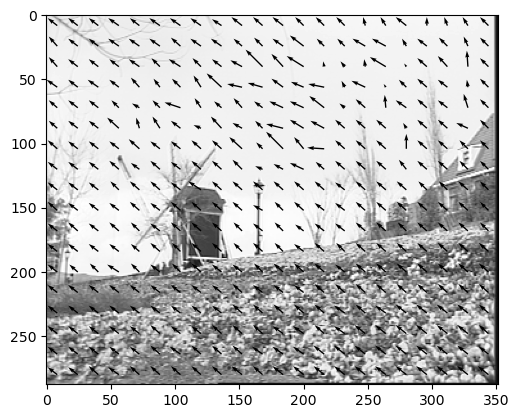

In [12]:
displayMVF(im1,mvf_ssd,brow)

Motion compensation: now that we have computed the movement vector field, we can compute the motion compensated image using the fracMc function. Display the motion compensated image. What can you observe ?

In [13]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp

Text(0.5, 1.0, 'Motion compensated image')

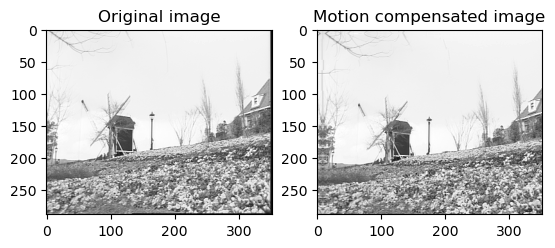

In [16]:
mc_ssd = fracMc(im1,mvf_ssd)
# Show the motion compensated image and the original image in a 2x1 grid
plt.figure()
plt.subplot(1,2,1)
plt.imshow(im2,cmap='gray')
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(mc_ssd,cmap='gray')
plt.title('Motion compensated image')

Compute the PSNR between the motion compensated and the current images.

Recall the definition of PSNR. Code the PSNR function. Compute it using the BM algorithm results, with different parameter values. Explain what you observe.

Is the PSNR between the motion-compensated image and im2 better than between im1 and im2 ? Explain why.

In [17]:
def PSNR(im1,im2):
    """
    Computes the PSNR between im1 and im2. The two images must have the same size.

    Parameters
    ----------
    im1, im2 : nparray
        Two images.

    Returns
    -------
    psnr : float
    """

    mse = np.mean((im1 - im2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

    # Values are usually between 20 and 40
    return psnr

In [18]:
psnr_ssd = PSNR(im2,mc_ssd)
print(psnr_ssd)

13.854289747305216


### I-1-b Unregularized SAD-based algorithm
Now, we will use the SAD as a metric for the block matching algorithm. To do that, implement the unregularized part of the me_sad algorithm. Please note that you function should be very similar to me_ssd, except for the metric (as such, as a starting point, you can copy paste what you have proposed for me_ssd).

In [19]:
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV

#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """ 
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR.astype(float) - CUR.astype(float))**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV

In [44]:
#%%
def me_sad(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    
    # Non-regularized search
    if lamb == 0.:
        for r in range(0, cur.shape[0], brow):
            for c in range(0, cur.shape[1], bcol):
                B = cur[r:r+brow, c:c+bcol]
                costMin = float('inf')
                Rbest = None
                
                for dcol in range(0, 2*search + 1):
                    for drow in range(0, 2*search + 1):
                        R = ref_extended[r+drow:r+drow+brow, c+dcol:c+dcol+bcol]
                        cost = np.sum(np.abs(B - R))
                        
                        if cost < costMin:
                            costMin = cost
                            Rbest = R
                            best_drow, best_dcol = drow, dcol
                
                mvf[r:r+brow, c:c+bcol, 0] = best_drow
                mvf[r:r+brow, c:c+bcol, 1] = best_dcol
                prediction[r:r+brow, c:c+bcol] = Rbest
                
    else: # Regularized search
        for r in range(0, cur.shape[0], brow):
            for c in range(0, cur.shape[1], bcol):
                B = cur[r:r+brow, c:c+bcol]
                costMin = float('inf')
                Rbest = None
                pV = computePredictor(r, c, brow, bcol, mvf, ref, cur)
                
                for dcol in range(0, 2*search + 1):
                    for drow in range(0, 2*search + 1):
                        R = ref_extended[r+drow:r+drow+brow, c+dcol:c+dcol+bcol]
                        sad_cost = np.sum(np.abs(B - R))
                        reg_cost = lamb * np.sum(np.abs(pV - np.array([drow, dcol])))
                        total_cost = sad_cost + reg_cost

                        if total_cost < costMin:
                            costMin = total_cost
                            Rbest = R
                            best_drow, best_dcol = drow, dcol

                mvf[r:r+brow, c:c+bcol, 0] = best_drow
                mvf[r:r+brow, c:c+bcol, 1] = best_dcol
                prediction[r:r+brow, c:c+bcol] = Rbest
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [21]:
mvf_sad, prediction =  me_sad(im2, im1, brow, bcol, search_radius)

Show the motion vector field using the displayMVF function. Do you see any difference with the SSD ? Explain.

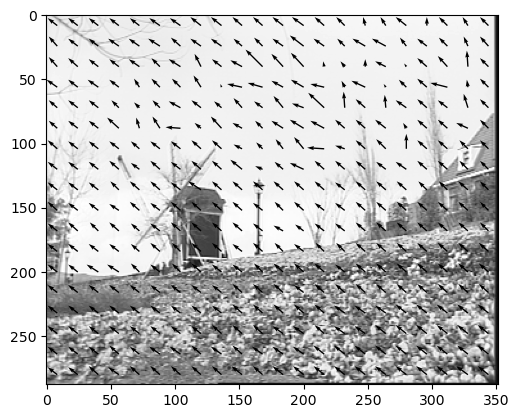

In [22]:
displayMVF(im1,mvf_sad,brow)

Motion compensation: compute the motion compensated image and display it. In addition, compute the PSNR.

Comment the difference observed between SSD and SAD in terms of regularity of the motion vector field, PSNR of the prediction and impact of the block size.

Text(0.5, 1.0, 'Motion compensated image')

<Figure size 640x480 with 0 Axes>

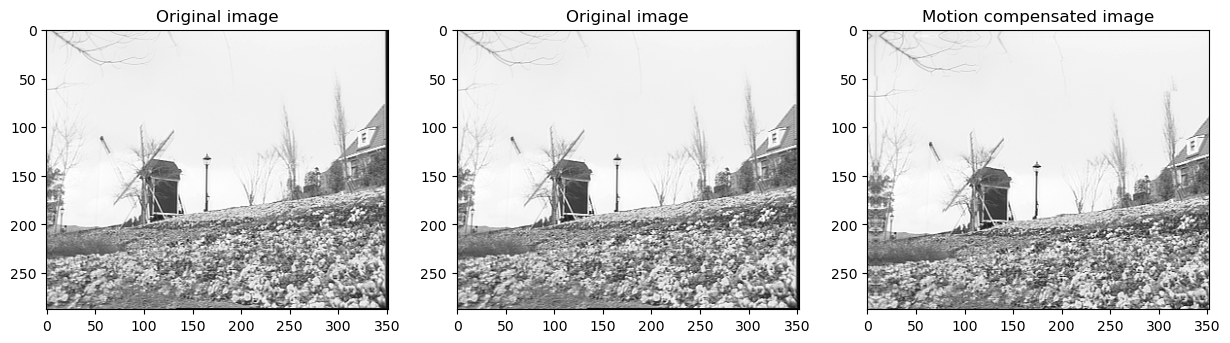

In [29]:
mc_sad = fracMc(im1,mvf_sad)
# Show the motion compensated image and the original images in t_0 and t_k in a 3x1 grid
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(im1,cmap='gray')
plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(im2,cmap='gray')
plt.title('Original image')
plt.subplot(1,3,3)
plt.imshow(mc_sad,cmap='gray')
plt.title('Motion compensated image')



In [30]:
psnr_sad = PSNR(im2,mc_sad)
print(psnr_sad)

13.858924601300117


## I-2- Regularized algorithms
Now, we will add a regularization term to the metrics (SSD and then SAD) we previously used.
### I-2-1- Regularized SSD-based algorithm

TO DO : code the regularized SSD-based algorithm.
For the sake of simplicity, the regularizing function is already given. How does it work and what does it compute?

Try several parameter values, and compare your results with the unregularized algorithms. What can you observe?

Text(0.5, 1.0, 'PSNR as a function of lambda for the SSD method')

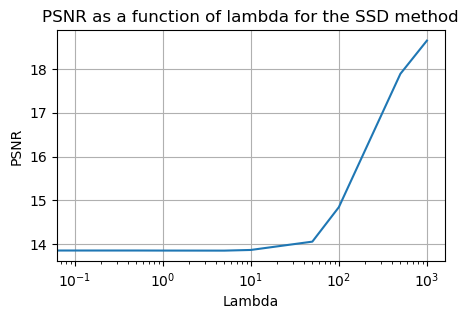

In [42]:
# Trying mvf_ssd for several values for lambda
lambdas = [0, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
psnrs = []
for lamb in lambdas:
    mvf_ssd, _ = me_ssd(im2, im1, brow, bcol, search_radius, lamb)
    mc_ssd = fracMc(im1,mvf_ssd)
    psnrs.append(PSNR(im2,mc_ssd))

plt.figure(figsize=(5,3))
plt.plot(lambdas, psnrs)
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('PSNR')
plt.grid()
plt.title('PSNR as a function of lambda for the SSD method')

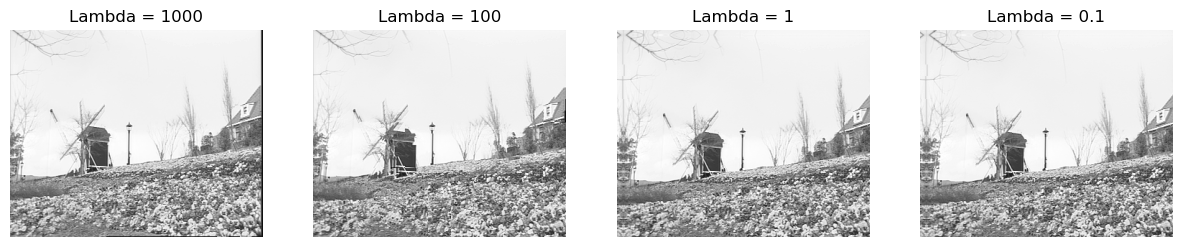

In [46]:
# Plotting the image for lambda = 1000, lambda = 100, lambda = 1 and lambda = 0.1
lambdas = [1000, 100, 1, 0.1]
plt.figure(figsize=(15,5))
for i, lamb in enumerate(lambdas):
    mvf_ssd, _ = me_ssd(im2, im1, brow, bcol, search_radius, lamb)
    mc_ssd = fracMc(im1,mvf_ssd)
    plt.subplot(1,4,i+1)
    plt.imshow(mc_ssd,cmap='gray')
    plt.title('Lambda = {}'.format(lamb))
    plt.axis('off')

### I-2-2- Regularized SAD-based algorithm

TO DO : code the regularized SAD-based algorithm.

Try several parameter values, and compare your results with the unregularized algorithms and the regularized SSD-based algorithm.

Text(0.5, 1.0, 'PSNR as a function of lambda for the SAD method')

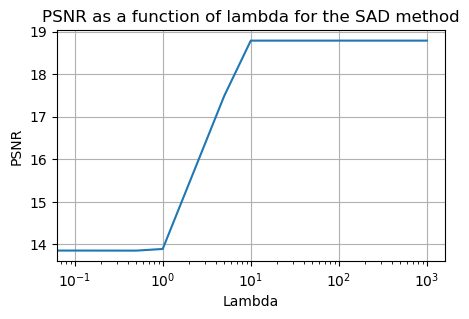

In [45]:
# Trying mvf_sad for several values for lambda
lambdas = [0, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
psnrs = []
for lamb in lambdas:
    mvf_sad, _ = me_sad(im2, im1, brow, bcol, search_radius, lamb)
    mc_sad = fracMc(im1,mvf_sad)
    psnrs.append(PSNR(im2,mc_sad))

plt.figure(figsize=(5,3))
plt.plot(lambdas, psnrs)
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('PSNR')
plt.grid()
plt.title('PSNR as a function of lambda for the SAD method')

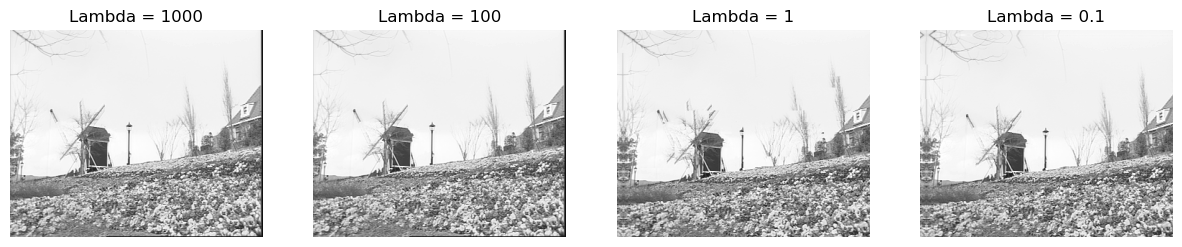

In [47]:
lambdas = [1000, 100, 1, 0.1]
plt.figure(figsize=(15,5))
for i, lamb in enumerate(lambdas):
    mvf_sad, _ = me_sad(im2, im1, brow, bcol, search_radius, lamb)
    mc_sad = fracMc(im1,mvf_sad)
    plt.subplot(1,4,i+1)
    plt.imshow(mc_sad,cmap='gray')
    plt.title('Lambda = {}'.format(lamb))
    plt.axis('off')

# Optical flow

You will now implement the Horn and Schunck algorithm to estimate the optic flow. The two images we will consider here have a more local movement vector field, since we are considering small movements in a face.

In [48]:
im1 = loadmat('akiyo_cif1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('akiyo_cif2.mat')['im2']
im2 = im2.astype('float')

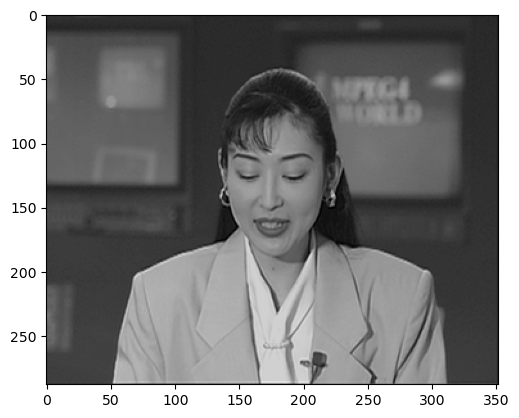

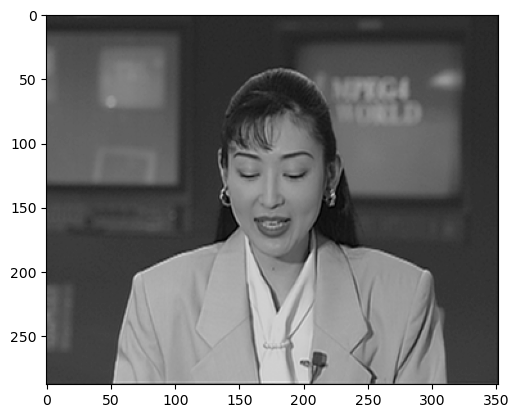

In [49]:
plt.figure()
plt.imshow(im1,cmap='gray')
plt.figure()
plt.imshow(im2,cmap='gray')

Compute the optical flow by filling the gaps in the Horn and Schunck function. You can use the motion field that you estimated before with the block matching algorithm to initialize the Horn and Schunck method.

As a reminder, the optical flow is implemented by the iterative Horn and Schunck's algorithm:
$$
u^{n+1} = \bar{u}^n - f_x \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
$$
v^{n+1} = \bar{v}^n - f_y \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
where $u^n$ is the value of the $u$ component at the $n$-th iteration, and $\bar{u}$ is the local average of $u$.

In [50]:
brow = 16; bcol=16; search_radius =13

In [51]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same')
    fx =-fx
    fy=-fy

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg = convolve2d(u,kernel_1,'same')
        vAvg = convolve2d(v,kernel_1,'same')
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - (fx*(fx*uAvg + fy*vAvg + ft))/(alpha**2 + fx**2 + fy**2)
        v = vAvg - (fy*(fx*uAvg + fy*vAvg + ft))/(alpha**2 + fx**2 + fy**2)
        
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

In [52]:
alpha = 100
ite = 100

# Rem: pay attention to the inversion of the order compare to me_ssd.
uInitial = np.zeros(np.shape(im1))
vInitial = np.zeros(np.shape(im1))
[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite,blur=1.)

Display the motion field and compute the PSNR. Do you observe any improvement compare to block-matching algorithms? Explain. You can test on both the Akiyo and Flowers images.

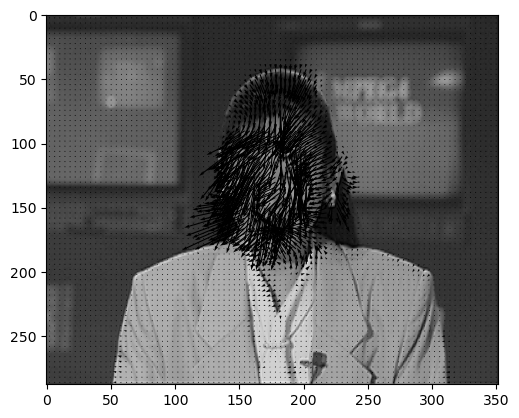

In [53]:
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)

mc_hs = fracMc(im1,mvf_hs)
psnr_hs = PSNR(im2,mc_hs)

In [54]:
psnr_hs

38.29293749234971